# Kinase Activity analysis + Kinase-Kinase network inference

This notebook shows how to, starting from a phosphoproteomics dataset containing site-level logFCs, infer kinase activities and a kinase-kinase interaction network. For the tutorial, we stick to the best performing resources and methods, but others are available as part of the `phosphonetworks` package. 

In [1]:
import phosphonetworks as pp
import networkx as nx
import pandas as pd
from plotnine import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Please note that some intermediate files are required for mapping ID purposes, so please download the data using the function below. 

In [2]:
target_dir = '/tmp/pp_test/'
pp.utils.download_manuscript_data(target_dir = target_dir)
# we also need to set this directory as the CACHE DIR for the rest of the analysis
pp.config.DATA_DIR = target_dir + 'phosphonetworks_data/'

Directory /tmp/pp_test/ already exists. Skipping download.


In [3]:
# load data from Bortel et al. 2024 (HeLa cells stimulated with EGF)
# other datasets are accesible in the df loaded by the package
egf_site_data = pp.phosphodata.get_egf_site_data()
print(egf_site_data['study'].unique())
egf_site_data = egf_site_data[
    (egf_site_data['study'] == 'Bortel et al. 2024 (HeLa)')
].copy()
egf_site_data

['Skowronek et al. 2022 (HeLa)' 'Bortel et al. 2024 (HeLa)'
 'Lancaster et al. 2024 (HeLa)' 'This study (HEK293T)'
 'This study (HEK293F)' 'This study (HEK293F TR)']


,id,logFC,AveExpr,t,P.Value,adj.P.Val,B,study,comparison
16307,P36507_S226,3.517599,13.959684,39.596446,1.819605e-23,4.050392e-19,40.661967,Bortel et al. 2024 (HeLa),8min
16308,P36507_S222,5.494241,12.029581,38.897764,2.778142e-23,4.050392e-19,40.364821,Bortel et al. 2024 (HeLa),8min
16309,P00533_Y1197,5.704730,12.982549,31.626753,1.537449e-20,1.120762e-16,35.218721,Bortel et al. 2024 (HeLa),8min
16310,P00533_Y1172,6.447228,13.069738,43.055058,2.701953e-21,2.626208e-17,34.464739,Bortel et al. 2024 (HeLa),8min
16311,Q9P0V3_S279,-1.867933,14.322482,-26.076733,3.451906e-19,2.013083e-15,32.960982,Bortel et al. 2024 (HeLa),8min
...,...,...,...,...,...,...,...,...,...
45461,Q8WWK9_T582,-0.001091,10.621359,-0.002012,9.984112e-01,9.991952e-01,-7.049432,Bortel et al. 2024 (HeLa),8min
45462,Q7Z422_S39,-0.000211,17.398730,-0.001436,9.988657e-01,9.994040e-01,-7.049433,Bortel et al. 2024 (HeLa),8min
45463,Q5VUA4_S2243,0.000073,14.796719,0.000854,9.993258e-01,9.996437e-01,-7.049434,Bortel et al. 2024 (HeLa),8min
45464,Q5SYE7_S941,0.000248,9.833768,0.000830,9.993444e-01,9.996437e-01,-7.049434,Bortel et al. 2024 (HeLa),8min


In [4]:
# prepare the kinase-substrate interactions only for the 'Moderate' cutoff
kinsub = pp.kinsub.get_one_cutoff_combined_kinsub(cutoff='Moderate')
kinsub

,source,target,score,resource
777456,O00141,A0A087WZG4_S1037,0.958000,kinlib
777457,O00141,A0A087WZG4_T658,0.986300,kinlib
777458,O00141,A0A0A0MRY4_T271,0.984700,kinlib
777459,O00141,A0A0A6YYC7_S82,0.997900,kinlib
777460,O00141,A0A0A6YYC7_S83,0.999600,kinlib
...,...,...,...,...
17061410,Q9Y6E0,P61006_T72,0.003906,literature
17061411,Q9Y6E0,Q15208_T444,0.007812,literature
17061412,Q9Y6E0,Q9Y2H1_T442,0.007812,literature
17061413,Q9Y6E0,Q9Y6E0_T190,0.011719,literature


In [5]:
# perform kinase activity analysis with different resources
kin_act_df = pp.methods.multi_resource_kinase_activity_analysis(
    site_df = egf_site_data,
    kinsub_df = kinsub
)
kin_act_df

Running analysis for resource: kinlib
Running analysis for resource: phosformer
Running analysis for resource: combined
Running analysis for resource: literature


,kinase,condition,activity,source,total_targets,proportion_sites_covered,resource
0,O00141,8min,19.686370,O00141,1612,0.726637,kinlib
1,O00238,8min,3.582357,O00238,823,0.726637,kinlib
2,O00311,8min,6.146648,O00311,1055,0.726637,kinlib
3,O00418,8min,-1.534926,O00418,798,0.726637,kinlib
4,O00444,8min,6.262605,O00444,932,0.726637,kinlib
...,...,...,...,...,...,...,...
1397,Q9H2X6,8min,-0.029289,Q9H2X6,8,0.043108,literature
1398,Q9H4A3,8min,0.579389,Q9H4A3,5,0.043108,literature
1399,Q9NRM7,8min,-0.711920,Q9NRM7,7,0.043108,literature
1400,Q9UQM7,8min,2.267382,Q9UQM7,15,0.043108,literature


/Users/mrodrigu/Desktop/phosphofireworks/src/phosphonetworks/viz.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


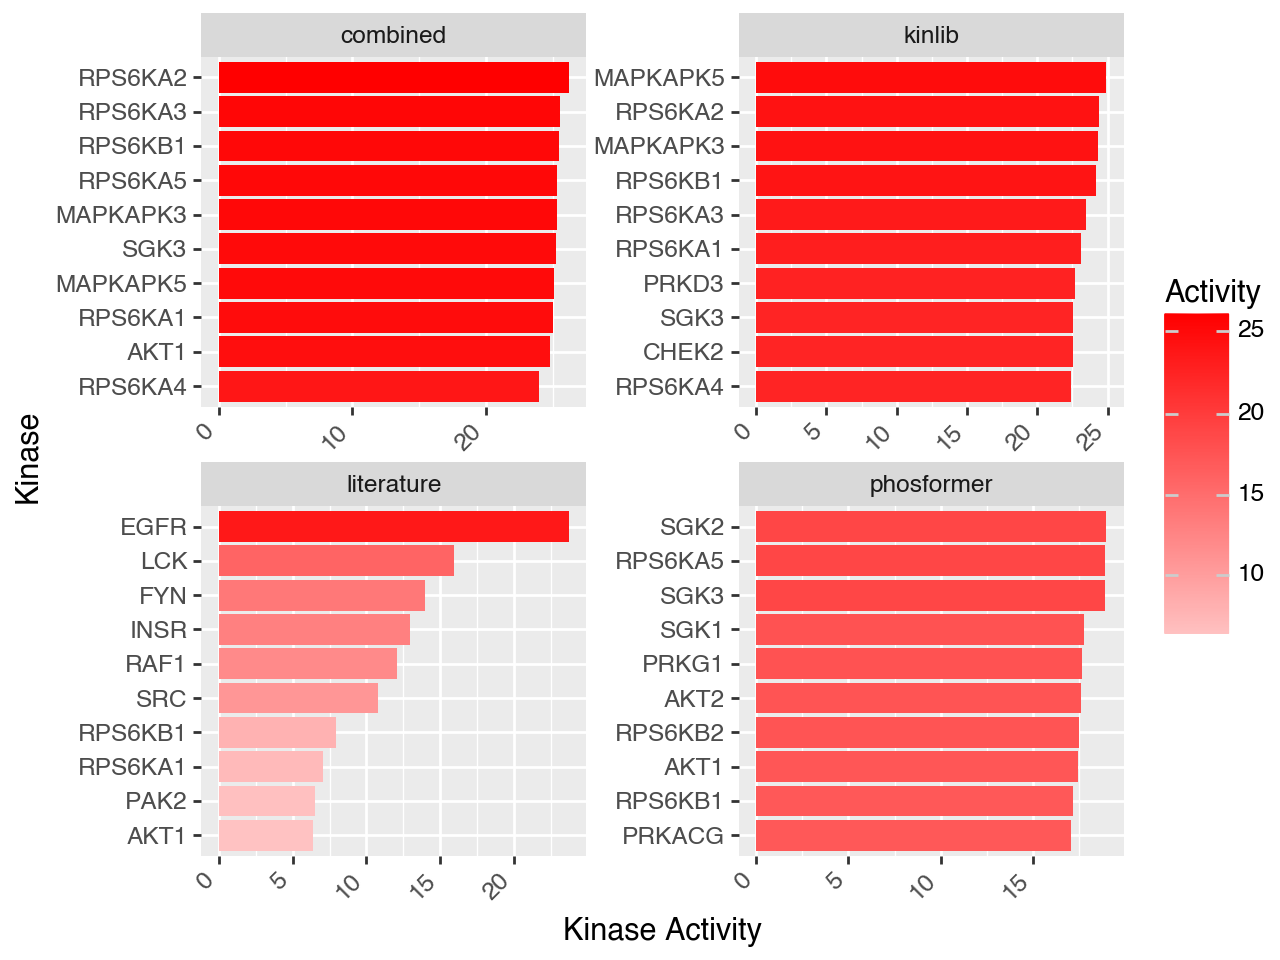

In [6]:
# we can now visualize, per resource, the top 10 most regulated kinases
pp.viz.plot_top_kinases(kin_act_df)

Initial number of terminals: 88
[FILTER TO NETWORK NODES]: 85
[FILTER TO REACHABLE FROM ROOT P00533]: 83
Final number of terminals: 83
PKN has 273 nodes and 815 edges
Min terminal value: 0.01248343338769195
Max terminal value: 23.69152535561857


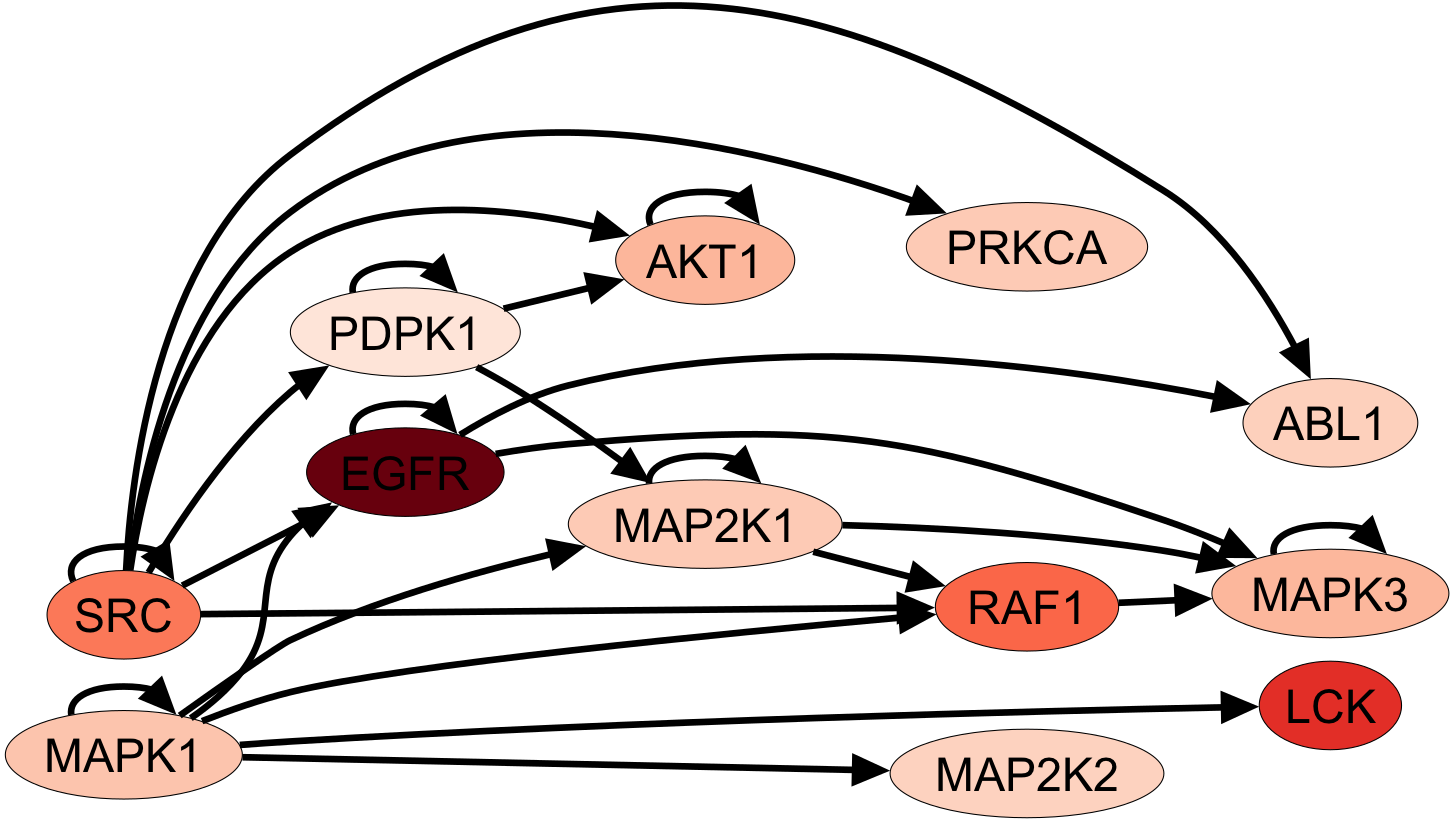

In [7]:
# and prepare the PKN and terminals to perform the network analysis
# we use 'literature' as resource and 'Personalized PageRank' as method
kk_pkn = pp.kinsub.get_kk_pkn()
kk_pkn = kk_pkn[kk_pkn['resource'] == 'literature'].copy()
kk_pkn = nx.from_pandas_edgelist(kk_pkn, 'source', 'target', edge_attr='weight')

terminals = kin_act_df[kin_act_df['resource'] == 'literature'].copy()
terminals['abs_activity'] = terminals['activity'].abs()
terminals = terminals.set_index('kinase')['abs_activity'].to_dict()

# here we use EGFR as root, but this can be changed
# for other datasets where a different protein is stimulated or inhibited
filt_pkn, filt_terminals = pp.utils.prepare_pkn_and_terminals(
    pkn = kk_pkn, 
    terminals = terminals, 
    root = 'P00533'
)

# select nodes and visualize
network = pp.network_methods.pagerank_selection(
    network = filt_pkn,
    terminals = filt_terminals,
    # here we set the number of edges in the resulting network
    n_edges = 25
)
pp.viz.render_graphviz(pp.viz.gv_continuous_node_highlight(network, filt_terminals))